# WNBA Assist Networks

Assists allow for the exploration of visualizing data in a network. Networks consist of nodes (players) and edges (assists) connecting the nodes. An assist can be thought of as a pair of two players with the assist traveling from the assisting player to the scorer, just as two nodes are connected by an edge. If a player has multiple assists to another player, the edge in the assist network can be weighted to represent the greater volume.

The following explores the `Shots` and `League` classes of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `pbp` and `commonallplayers` endpoints of the [stats.nba.com](https://stats.nba.com). The goal of this analysis is to build assist networks that communicate meaningful insights.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time

from py_ball import wnba_shots, league

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

ID_TO_TEAM_WNBA = {1611661330: 'Atlanta Dream', 1611661321: 'Dallas Wings',
                   1611661320: 'Los Angeles Sparks', 1611661317: 'Phoenix Mercury',
                   1611661329: 'Chicago Sky', 1611661325: 'Indiana Fever',
                   1611661324: 'Minnesota Lynx', 1611661328: 'Seattle Storm',
                   1611661323: 'Connecticut Sun', 1611661319: 'Las Vegas Aces',
                   1611661313: 'New York Liberty', 1611661322: 'Washington Mystics'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `Shots` class requires a few parameters:
- season: YYYY season year format
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 season game between the Liberty and the Fever.

In [2]:
game_id = '1021900013'
season = '2019'

assists = wnba_shots.Shots(headers=HEADERS,
                           game_id=game_id,
                           season=season)
assist_df = pd.DataFrame(assists.data)
assist_df.head(15)

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs
0,10:00,Start Period,,12,2,0,0,-80,0,0,,0,0,20000,0,0,0
1,09:57,Jump Ball Williams vs Sanders (Breland gains p...,202638,10,4,0,0,-80,0,1611661330,201506,0,0,60000,204322,1611661330,0
2,09:39,[ATL] Williams Driving Hook Shot: Missed,,2,7,0,-44,33,57,1611661330,,2,0,70000,204322,1611661330,0
3,09:35,[WAS] Sanders Rebound (Off:0 Def:1),,4,8,0,-44,33,0,1611661330,,0,0,80000,201506,1611661322,0
4,09:27,[ATL] Montgomery Foul: Personal (1 PF),,6,9,0,7,66,1,1611661322,1628878,0,0,90000,201904,1611661330,0
5,09:22,[WAS 2-0] Delle Donne Jump Shot: Made (2 PTS) ...,204333,1,11,2,-125,101,1,1611661322,,2,0,110000,203399,1611661322,0
6,09:14,[ATL] Montgomery Turnover : Bad Pass (1 TO) St...,,5,13,2,14,735,1,1611661330,201911,1,0,130000,201904,1611661330,0
7,09:08,[WAS 4-0] Toliver Layup Shot: Made (2 PTS),,1,15,4,-12,27,5,1611661322,,2,1,150000,201911,1611661322,0
8,08:51,[ATL] Breland Layup Shot: Missed,,2,16,4,32,63,5,1611661330,,2,0,160000,202638,1611661330,0
9,08:48,[WAS] Delle Donne Rebound (Off:0 Def:1),,4,17,4,32,63,0,1611661330,,0,0,170000,203399,1611661322,0


Because players are identified by their player ID number in the play-by-play data, player metadata is needed so as to identify players by name in the assist network.

In [3]:
league_id = '10'

players = league.League(headers=HEADERS,
                        endpoint='commonallplayers',
                        league_id=league_id,
                        season=season)
player_df = pd.DataFrame(players.data['CommonAllPlayers'])
player_df.head(15)

,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,FROM_YEAR,GAMES_PLAYED_FLAG,IS_NBA_ASSIGNED,NBA_ASSIGNED_TEAM_ID,PERSON_ID,PLAYERCODE,ROSTERSTATUS,TEAM_ABBREVIATION,TEAM_CITY,TEAM_CODE,TEAM_ID,TEAM_NAME,TO_YEAR
0,Natalie Achonwa,"Achonwa, Natalie",2015,Y,0,0,203831,natalie_achonwa,1,IND,Indiana,fever,1611661325,Fever,2019
1,Rebecca Allen,"Allen, Rebecca",2015,Y,0,0,204296,rebecca_allen,1,NYL,New York,liberty,1611661313,Liberty,2019
2,Kristine Anigwe,"Anigwe, Kristine",2019,Y,0,0,1629485,kristine_anigwe,1,CON,Connecticut,sun,1611661323,Sun,2019
3,Ariel Atkins,"Atkins, Ariel",2018,Y,0,0,1628878,ariel_atkins,1,WAS,Washington,mystics,1611661322,Mystics,2019
4,Seimone Augustus,"Augustus, Seimone",2006,Y,0,0,200671,seimone_augustus,1,MIN,Minnesota,lynx,1611661324,Lynx,2019
5,Rachel Banham,"Banham, Rachel",2016,Y,0,0,1627671,rachel_banham,1,CON,Connecticut,sun,1611661323,Sun,2019
6,Alana Beard,"Beard, Alana",2004,Y,0,0,100949,alana_beard,1,LAS,Los Angeles,sparks,1611661320,Sparks,2019
7,Alex Bentley,"Bentley, Alex",2013,Y,0,0,203410,alex_bentley,1,ATL,Atlanta,dream,1611661330,Dream,2019
8,Tiffany Bias,"Bias, Tiffany",2014,Y,0,0,203839,tiffany_bias,1,NYL,New York,liberty,1611661313,Liberty,2019
9,Monique Billings,"Billings, Monique",2018,Y,0,0,1628881,monique_billings,1,ATL,Atlanta,dream,1611661330,Dream,2019


Let's isolate all of the assists to view the data:

In [4]:
assist_df[(assist_df['epid']!='') & (assist_df['etype']==1)]

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs
5,09:22,[WAS 2-0] Delle Donne Jump Shot: Made (2 PTS) ...,204333,1,11,2,-125,101,1,1611661322,,2,0,110000,203399,1611661322,0
17,07:32,[WAS 8-2] Atkins Running Layup Shot: Made (2 P...,204333,1,26,8,21,24,41,1611661322,,2,0,260000,1628878,1611661322,2
21,06:44,[WAS 10-2] Delle Donne Pullup Jump shot: Made ...,201911,1,32,10,-131,126,79,1611661322,,2,0,320000,203399,1611661322,2
30,05:32,[WAS 12-5] Toliver Pullup Jump shot: Made (4 P...,1628878,1,46,12,-190,33,79,1611661322,,2,0,460000,201911,1611661322,5
45,04:16,[WAS 14-9] Delle Donne Jump Shot: Made (8 PTS)...,201911,1,66,14,153,-4,1,1611661322,,2,0,660000,203399,1611661322,9
61,02:39,[WAS 21-12] Toliver 3pt Shot: Made (7 PTS) Ass...,1628878,1,87,21,209,168,1,1611661322,,3,1,870000,201911,1611661322,12
62,02:17,[ATL 14-21] Williams Cutting Layup Shot: Made ...,203410,1,89,21,4,51,98,1611661330,,2,0,890000,204322,1611661330,14
85,00:39.7,[WAS 24-14] Hines-Allen Hook Shot: Made (3 PTS...,203416,1,121,24,-19,61,3,1611661322,,2,0,1210000,1628899,1611661322,14
86,00:29.0,[ATL 16-24] Gülich Layup Shot: Made (2 PTS) As...,203410,1,123,24,8,30,5,1611661330,,2,0,1230000,1628895,1611661330,16
104,08:13,[WAS 33-16] Hawkins 3pt Shot: Made (3 PTS) Ass...,204333,1,148,33,100,222,1,1611661322,,3,0,1480000,203403,1611661322,16


To create a network, we need to establish both nodes and edges. Each edge goes from a source node (assisting player) to a target node. The `network_data` function below also establishes coordinates for each node, along with the number of assists for each player. 

In [17]:
def network_data(pbp_df, team_id):
    """ network_dict creates nodes and edges
    for an assist network, along with information
    needed to plot the network

    @param pbp_df (DataFrame): DataFrame of play-by-play
        data with timeouts removed. Timeouts cause complications
        with getting players from the 'epid' field

    @param team_id (int): Unique team identifier

    Returns

        unique_players (list): List of player ID numbers
            corresponding to players on the team given

        edges (list): List of tuples in the form
            (assisting player ID, scoring player ID, number of assists)

        pos_dict (dict): Dictionary with keys of player ID numbers
            with (x, y) values corresponding to node coordinates

        weights (dict): Dictionary with keys of player ID numbers
            with assists as values
    """

    # First, let's identify all players on the team provided
    network = {}
    team_df = pbp_df[pbp_df['tid'] == team_id]
    unique_players = list(set(list(team_df['pid']) + list(team_df['epid'])))
    unique_players.remove('')
    unique_players.remove(0)
    unique_players = list(set([int(x) for x in unique_players]))

    # Next, we'll isolate the assists and loop through all unique assist
    # partners (assisting player, scorer)
    assist_df = team_df[(team_df['epid']!='') & (team_df['etype']==1)]
    network['links'] = {}
    count = 0
    all_assists = zip(assist_df['epid'], assist_df['pid'])
    all_assists = [(int(x), int(y)) for x, y in all_assists]
    unique_assists = list(set(all_assists))
    weights = {}
    for source, target in unique_assists:
        network['links'][count] = {}
        network['links'][count]['source'] = source
        network['links'][count]['target'] = target
        network['links'][count]['weight'] = sum([1 if x == (source, target) else 0 for x in all_assists])
        weights[(source, target)] = network['links'][count]['weight']
        count += 1

    links = len(network['links'])
    edges = [(network['links'][k]['source'],
              network['links'][k]['target'],
              network['links'][k]['weight']) for k in range(links)]

    # Finally, we'll get coordinates for all players in the assist
    # network around the unit circle
    angles = np.linspace(0, 360 - 360/float(len(unique_players)), len(unique_players))
    pos_dict = {}
    for angle, player in zip(angles, unique_players):
        pos_dict[player] = (np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle)))

    return unique_players, edges, pos_dict, weights

In [18]:
team_id = 1611661322
nodes, edges, positions, weights = network_data(assist_df[(assist_df['etype']!=9) &
                                                          (assist_df['etype']!=6)], team_id)

In [21]:
def plot_network(nodes, edges, positions, weights, players, team):
    """ plot_network plots the assist network given the
    data from the network_data function.

    @param nodes (list): List of player ID numbers
        corresponding to players on the team given

    @param edges (list): List of tuples in the form
        (assisting player ID, scoring player ID, number of assists)

    @param positions (dict): Dictionary with keys of player ID numbers
         with (x, y) values corresponding to node coordinates

    @param weights (dict): Dictionary with keys of player ID numbers
        with assists as values

    @param players (DataFrame): DataFrame of player metadata including
        the fields PERSON_ID and DISPLAY_FIRST_LAST

    @param team (int): Unique team identifier

    Returns

        fig (maplotlib.figure.Figure): Assist network visual
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')
    plt.title(ID_TO_TEAM_WNBA[team] + ' Assist Network', fontsize=18)

    # First, let's plot each node, labeling each with player name and
    # number of assists. The number of assists also control the markersize
    # of the nodes. Because of this and varying name lengths, the name
    # position is perturbed to ensure proper formatting
    for pos in positions:
        assists = sum([weights[x] if x[0] == pos else 0 for x in weights])
        plt.plot(positions[pos][0], positions[pos][1], marker='o',
                 markersize=(1 + assists)*5, markeredgecolor='k', fillstyle='none')
        name = players[players['PERSON_ID']==pos]['DISPLAY_FIRST_LAST'].iloc[0] + ' (' + str(int(assists)) + ')'
        if positions[pos][1] == 1:
            vertical_perturb = 0.003*(1 + assists)*5
        elif positions[pos][1] == -1:
            vertical_perturb = -0.005*(1 + assists)*5 - 0.05
        else:
            vertical_perturb = 0

        if positions[pos][0] < 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = -0.0325*len(name) - 0.0025*(1 + assists)*5
        elif positions[pos][0] >= 0 and abs(positions[pos][1]) != 1:
            horiz_perturb = 0.0025*len(name) + 0.0025*(1 + assists)*5
        else:
            horiz_perturb = -0.0175*len(name)
            
        plt.text(positions[pos][0] + horiz_perturb, positions[pos][1] + vertical_perturb,
                 name, fontsize=12)

    # Next, the edges are plotted as arrows with the arrow going from 
    # the assisting player to the scoring player. The size of the arrow
    # is a function of the number of assists for that directed pair.
    # Also, the transparency is set to 0.5 to account for instances
    # when a pair of players have assists to each other.
    for edge in edges:
        node1 = edge[0]
        node2 = edge[1]
        assists = edge[2]

        start_x = positions[node1][0]
        start_y = positions[node1][1]

        delta_x = positions[node2][0] - start_x
        delta_y = positions[node2][1] - start_y

        plt.arrow(start_x, start_y, delta_x, delta_y, width=0.01*assists,
                  length_includes_head=True, alpha=0.5)

    plt.ylim(-1.2, 1.2)
    plt.xlim(-1.2, 1.2)
    axis.set_aspect(1.0)
    plt.axis('off')
    plt.close()

    return fig

In [22]:
network = plot_network(nodes, edges, positions, weights, player_df, team_id)

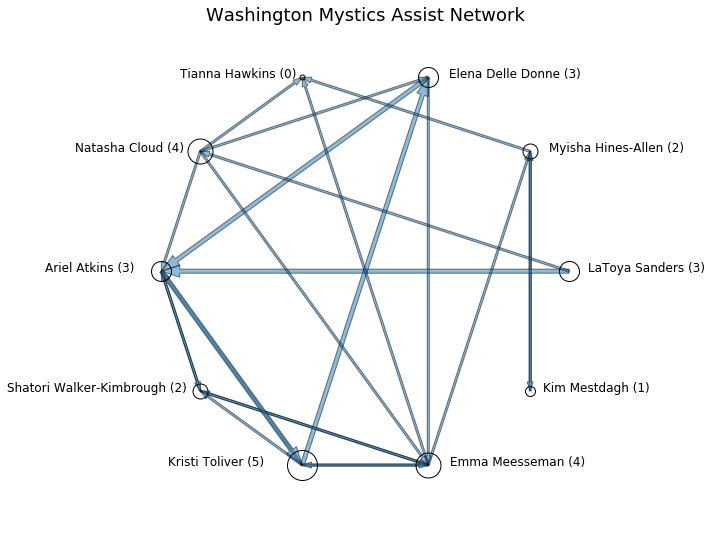

In [23]:
network

The assist network communicates a lot of information in a compact form:
    - Erica Wheeler led the team with six assists and distributed them to five different teammates
    - Each player either had an assist or scored an assisted basket
    - Kelsey Mitchell was the beneficiary of five assists
    - The greatest number of assists from one player to another is two
    - Two pairs had assists to each other: Tiffany Mitchell and Kelsey Mitchell, along with Paris Kea and Stephanie Mavunga.
    
## Exploration

    - What else can you add or change about the above assist network to enhance the visualization?
    - What other events in basketball could be visualized by a network?